In [10]:
# %%
# Import necessary libraries
import sys
import torch
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
import os
import importlib.util
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go


In [11]:
# %%
# Specify the path to run.py
run_py_path = "./run.py"  # Adjust this path if run.py is located elsewhere

# Check if run.py exists
if not os.path.exists(run_py_path):
    raise FileNotFoundError(f"Cannot find run.py at {run_py_path}")

# Dynamically load run.py as a module named 'grig'
spec = importlib.util.spec_from_file_location("grig", run_py_path)
grig = importlib.util.module_from_spec(spec)
spec.loader.exec_module(grig)

print("Successfully imported run.py as 'grig' module.")


Successfully imported run.py as 'grig' module.


In [12]:
# %%
# Define the path to the trained clustering.npz file
clustering_filepath = "clustering.npz"  # Adjust the path if necessary

# Check if clustering.npz exists
if not os.path.exists(clustering_filepath):
    raise FileNotFoundError(f"Cannot find clustering.npz at {clustering_filepath}")

# Load scene_data and clustering from the saved file
scene_data, clustering = grig.load_scene_and_clustering(clustering_filepath)

print("Loaded scene_data and clustering from", clustering_filepath)
print(f"Number of timesteps: {len(scene_data)}")
print(f"Number of clusters: {clustering.num_clusters}")


Loaded scene_data and clustering from clustering.npz
Number of timesteps: 150
Number of clusters: 28


In [13]:
# %%
# Perform joint solving
# Find cluster chains
max_distance = 0.5  # Adjust based on your data
cluster_chains = grig.find_nearest_neighbor_chains_all_timesteps(clustering, max_distance=max_distance)

# Compute joints
joints_t = grig.compute_joints(clustering, cluster_chains)

print(f"Number of joint chains found: {len(cluster_chains)}")
print(f"Number of joints computed: {joints_t.shape[1]}")


Found 2 chains of clusters.
Computed 26 joints.
Number of joint chains found: 2
Number of joints computed: 26


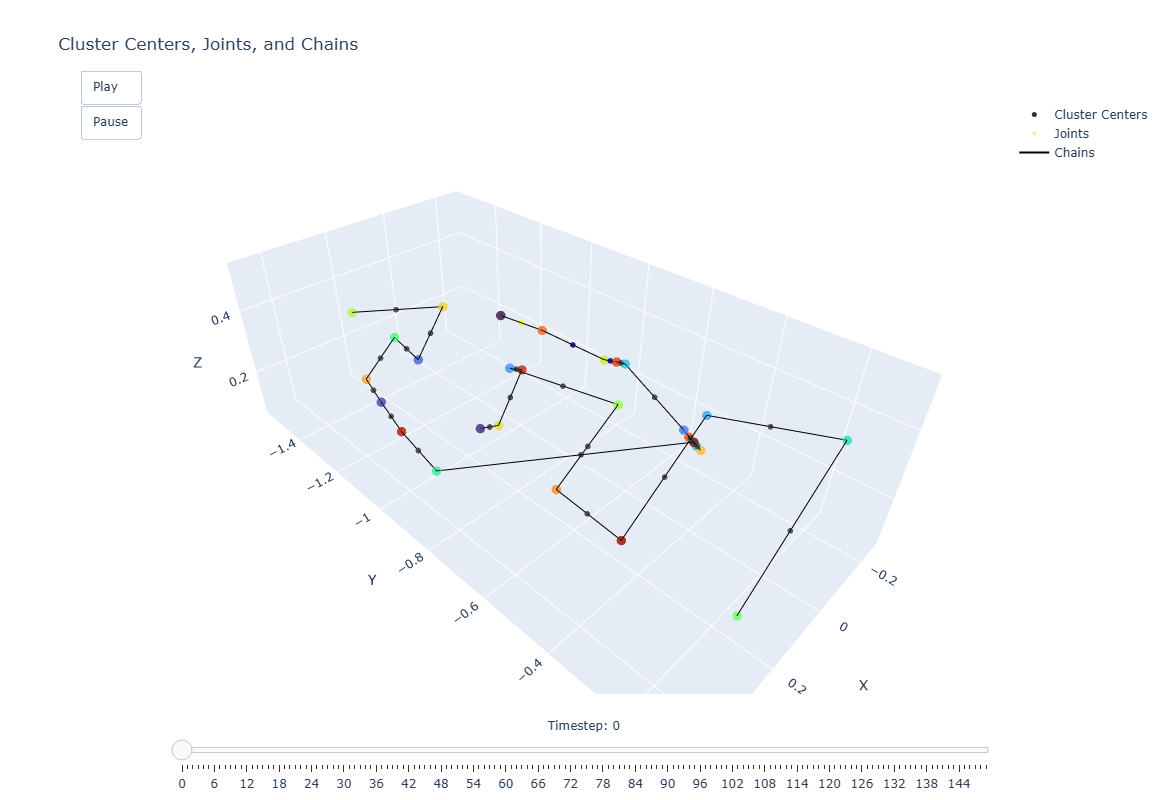

In [19]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.cm as cm

# Assuming the following variables are already defined:
# clustering: Clustering object with 'centers' attribute (T, K, 3)
# cluster_chains: List of lists containing cluster indices
# joints_t: numpy array of shape (T, num_joints, 3)

# Extract data
centers_t = clustering.centers.cpu().numpy()  # Shape: (T, K, 3)
joints = joints_t  # Shape: (T, num_joints, 3)
num_timesteps = centers_t.shape[0]
num_clusters = centers_t.shape[1]
num_joints = joints.shape[1]

# Define color maps
cmap = cm.get_cmap('turbo', num_clusters)
cluster_colors = [cmap(i)[:3] for i in range(num_clusters)]  # RGB tuples

# Define joint color as red
joint_color = [1, 0, 0]  # Red

# Prepare cluster chains for lines
# Each chain is a list of cluster indices
chain_lines = []
for chain in cluster_chains:
    if len(chain) < 2:
        continue
    for i in range(len(chain) - 1):
        start_idx = chain[i]
        end_idx = chain[i + 1]
        chain_lines.append((start_idx, end_idx))

# Function to create scatter trace for cluster centers
def create_cluster_trace(centers, colors):
    trace = go.Scatter3d(
        x=centers[:, 0],
        y=centers[:, 1],
        z=centers[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=colors,
            opacity=0.8
        ),
        name='Cluster Centers'
    )
    return trace

# Function to create scatter trace for joints
def create_joints_trace(joints_at_t):
    trace = go.Scatter3d(
        x=joints_at_t[:, 0],
        y=joints_at_t[:, 1],
        z=joints_at_t[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=joint_color,
            opacity=0.9
        ),
        name='Joints'
    )
    return trace

# Function to create lines for chains
def create_chains_trace(centers_at_t, chain_lines):
    if not chain_lines:
        return None
    # Prepare line segments
    x_lines = []
    y_lines = []
    z_lines = []
    for start, end in chain_lines:
        x_lines.extend([centers_at_t[start, 0], centers_at_t[end, 0], None])
        y_lines.extend([centers_at_t[start, 1], centers_at_t[end, 1], None])
        z_lines.extend([centers_at_t[start, 2], centers_at_t[end, 2], None])
    
    trace = go.Scatter3d(
        x=x_lines,
        y=y_lines,
        z=z_lines,
        mode='lines',
        line=dict(
            color='black',  # Changed from 'green' to 'black'
            width=2
        ),
        name='Chains'
    )
    return trace

# Initialize the first frame
initial_centers = centers_t[0]
initial_joints = joints[0]

# Create initial traces
cluster_trace = create_cluster_trace(initial_centers, cluster_colors)
joints_trace = create_joints_trace(initial_joints)
chains_trace = create_chains_trace(initial_centers, chain_lines)

# Create frames for animation
frames = [
    go.Frame(
        data=[
            create_cluster_trace(centers_t[t], cluster_colors),
            create_joints_trace(joints[t]),
            create_chains_trace(centers_t[t], chain_lines)
        ],
        name=str(t)
    )
    for t in range(num_timesteps)
]

# Create the figure with increased size
fig = go.Figure(
    data=[cluster_trace, joints_trace, chains_trace],
    layout=go.Layout(
        title="Cluster Centers, Joints, and Chains",
        width=1200,    # Increased width
        height=800,    # Increased height
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z'),
            aspectmode='data'
        ),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(label="Play",
                         method="animate",
                         args=[None, {"frame": {"duration": 50, "redraw": True},
                                      "fromcurrent": True}]),
                    dict(label="Pause",
                         method="animate",
                         args=[[None], {"frame": {"duration": 0, "redraw": False},
                                        "mode": "immediate",
                                        "transition": {"duration": 0}}])
                ],
                showactive=False,
                x=0,
                y=1.05,
                xanchor="left",
                yanchor="top"
            )
        ]
    ),
    frames=frames
)

# Add sliders
fig.update_layout(
    sliders=[
        dict(
            steps=[
                dict(
                    method='animate',
                    args=[
                        [str(t)],
                        dict(mode='immediate', frame=dict(duration=50, redraw=True), transition=dict(duration=0))
                    ],
                    label=str(t)
                )
                for t in range(num_timesteps)
            ],
            transition=dict(duration=0),
            x=0.1,
            y=0,
            currentvalue=dict(font=dict(size=12), prefix='Timestep: ', visible=True, xanchor='center'),
            len=0.9
        )
    ]
)

# Display the figure
fig.show()
